<a href="https://colab.research.google.com/github/Badm0nting/image-to-image/blob/main/image_to_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Install Required Libraries**

In [ ]:
!pip install tensorflow matplotlib
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-yx_gdo_s
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-yx_gdo_s
  Resolved https://github.com/tensorflow/examples.git to commit 3c7435733a9162481df350e57c53e58d2a705e4d
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1746868094.345130988853936603129253091149118257392589495885-py3-none-any.whl size=301646 sha256=4eccfa0a4d9b72a40f708bf31709c368df7e336a782d44f00d6ae0c639b8f318
  Stored in directory: /tmp/pip-ephem-wheel-cache-d7yv6odj/wheels/91/9b/e8/6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples


# **Step 2: Import Necessary Libraries**

In [ ]:
import os
import tensorflow as tf
import tarfile
import pathlib

# Step 1: Download the tar.gz file
url = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz"
download_dir = tf.keras.utils.get_file("facades.tar.gz", origin=url, extract=False)

# Step 2: Manually extract it
extract_path = os.path.join(os.path.dirname(download_dir), "facades")

if not os.path.exists(extract_path):
    with tarfile.open(download_dir, "r:gz") as tar:
        tar.extractall(path=os.path.dirname(download_dir))

# Step 3: Confirm contents
print("Extracted files:", os.listdir(extract_path))
print("Train dir:", os.listdir(os.path.join(extract_path, "train"))[:3])

# Step 4: Set the correct path
PATH = pathlib.Path(extract_path)
train_dataset = tf.data.Dataset.list_files(str(PATH / "train/*.jpg"))

Extracted files: ['train', 'test', 'val']
Train dir: ['298.jpg', '265.jpg', '358.jpg']


# **Step 3: Load and Preprocess the Dataset**

In [ ]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'
path_to_zip = tf.keras.utils.get_file('facades.tar.gz', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

##Define Preprocessing Functions

In [ ]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, :w, :]
    real_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

##Apply Data Augmentation

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
    # Resize to 286x286 then crop back to 256x256
    input_image, real_image = resize(input_image, real_image, 286, 286)
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, 256, 256, 3])
    input_image, real_image = cropped_image[0], cropped_image[1]

    # Random mirroring
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

# **Step 4: Create Input Pipeline**

In [ ]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, 256, 256)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

train_dataset = tf.data.Dataset.list_files(PATH + 'train/*.jpg')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(400).batch(1)

test_dataset = tf.data.Dataset.list_files(PATH + 'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

# **Step 5: Build the Generator (U-Net)**

In [ ]:
OUTPUT_CHANNELS = 3

generator = tf.keras.Sequential([])

from tensorflow_examples.models.pix2pix import pix2pix
generator = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='batchnorm')

# **Step 6: Build the Discriminator (PatchGAN)**

In [ ]:
discriminator = pix2pix.discriminator(norm_type='batchnorm', target=True)

# **Step 7: Define Loss Functions**

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss

# **Step 8: Set Up Optimizers and Checkpoints**

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# **Step 9: Train the Model**

In [ ]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

def fit(train_ds, epochs):
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}')
        for input_image, target in train_ds:
            train_step(input_image, target)
        checkpoint.save(file_prefix=checkpoint_prefix)

##Call training:

In [ ]:
fit(train_dataset, epochs=30)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30


# **Step 10: Generate and Visualize Output**

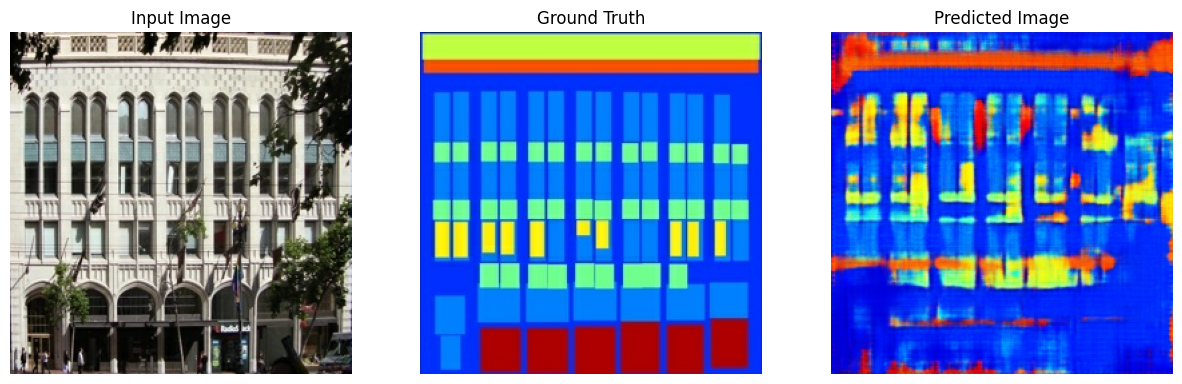

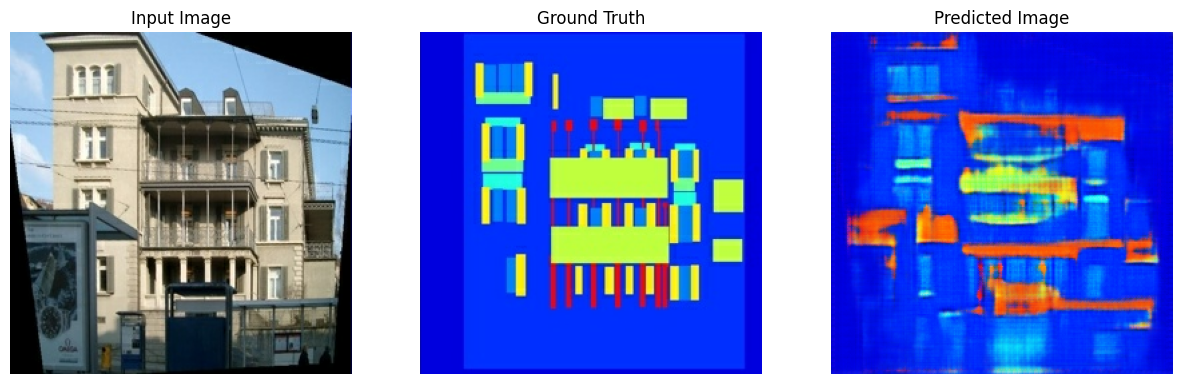

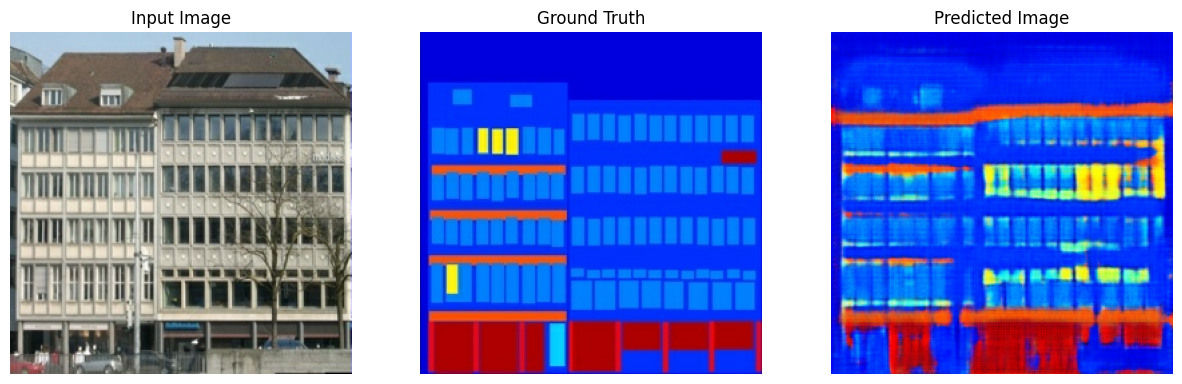

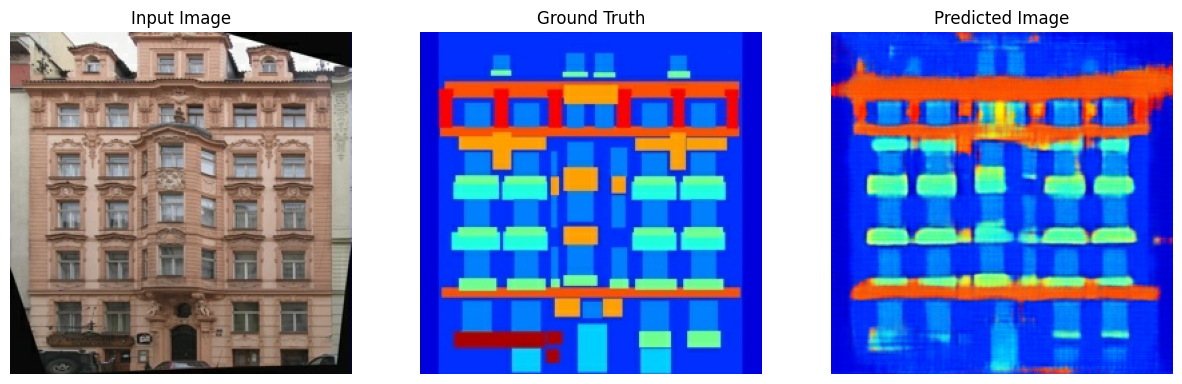

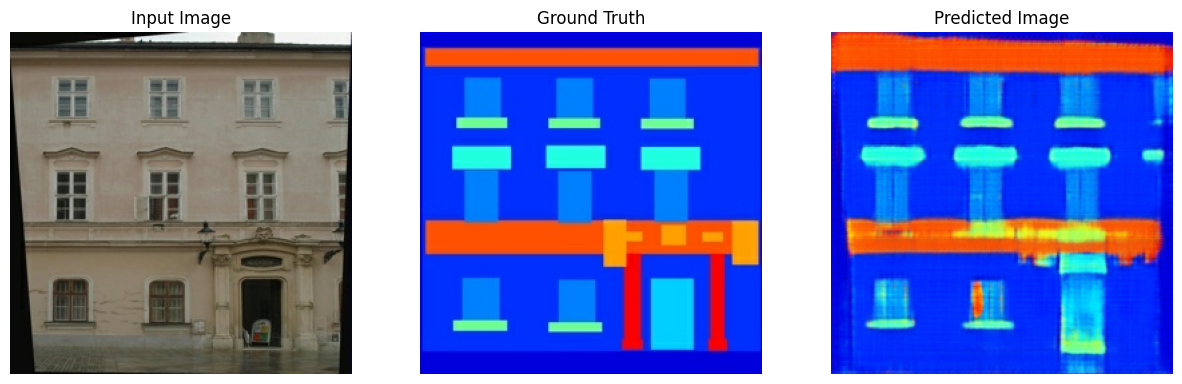

In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2.0)
        plt.axis('off')
    plt.show()

for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)